In [1]:
import jax
import jax.numpy as jnp
import jax.random as jr 

import flowjax
from flowjax.bijections import (
    Affine,
    Invert,
    MaskedAutoregressive,
    RationalQuadraticSpline,
    Stack,
    Tanh,
    Identity
)
from flowjax.bijections.utils import Identity
from flowjax.distributions import Normal, Transformed, Uniform, _StandardUniform
from flowjax.flows import masked_autoregressive_flow
from flowjax.train import fit_to_data
from flowjax.wrappers import NonTrainable
from flowjax.utils import arraylike_to_array
from frugal_flows.bijections import UnivariateNormalCDF

import matplotlib.pyplot as plt
import equinox as eqx
from collections.abc import Callable
import jax.nn as jnn
from typing import ClassVar

seed = 5

In [2]:
# Set the random seed
key = jr.PRNGKey(seed)

# Generate N Bernoulli samples
N = 10000
p = 0.5
x = jr.bernoulli(key, p=p, shape=(N, 1)).astype(int)

# Calculate y conditional on x
mean = 5 * x  + 2
std_dev = 1
noise = jr.normal(jr.PRNGKey(seed+1), shape=(N,1))

# Generate Gaussian variables with specified mean and standard deviation
y = std_dev * noise + mean

In [15]:
ate=5.
const=3.
scale=3.
bij = Stack([UnivariateNormalCDF(
    ate=ate, 
    const=const, 
    scale=scale, 
    cond_dim=1
)])

In [16]:
bij

Stack(
  shape=(1,),
  cond_shape=(1,),
  bijections=[
    UnivariateNormalCDF(
      shape=(),
      cond_shape=(1,),
      ate=f32[],
      scale=f32[],
      const=f32[]
    )
  ],
  axis=0
)

In [17]:
bij.transform(y[0], x[0])

IndexError: Too many indices for array: 1 non-None/Ellipsis indices for dim 0.

In [26]:
y_parts = bij._split_and_squeeze(y)
x_parts = [
    bij.transform(y, x)
    for (b, y) in zip(bij.bijections, y_parts, strict=True)
]

NameError: name 'self' is not defined

In [21]:
ate, scale, const = jnp.broadcast_arrays(
    *(arraylike_to_array(a, dtype=float) for a in (ate, scale, const)),
)
location = ate * x[0][0] + const
jax.scipy.stats.norm.cdf(y[0][0], loc=location, scale=scale)

Array(0.2531423, dtype=float32)

In [8]:
xsing = jnp.array(8)
cond = jnp.array(1)
ate = jnp.array(5)
const = jnp.array(3)
loc = ate * xsing + const
scale = jnp.array(1)
print(jax.scipy.stats.norm.cdf(xsing, ate * cond + const, scale))
print(jax.scipy.special.ndtri(jnp.array(0.5))* scale + const)

0.5
3.0


In [9]:
ate * xsing + consti

Array(43, dtype=int32, weak_type=True)

In [52]:
loc.flatten()

Array([43], dtype=int32)

In [54]:
jax.scipy.stats.norm.logpdf(jnp.array(8), loc=2, scale=1).shape

(1,)

In [14]:
nvars = 1
key, subkey = jr.split(jr.PRNGKey(seed))

base_dist = flowjax.distributions._StandardUniform((1,))

# base_dist = Uniform(-jnp.zeros(nvars), jnp.ones(nvars))
marginal_transform = Stack([UnivariateNormalCDF(
    ate=5., 
    const=3., 
    scale=3., 
    cond_dim=1
)])
flow = Transformed(base_dist, Invert(marginal_transform))

key, subkey = jr.split(key)

# Train 
flow, losses = fit_to_data(
    key=subkey,
    dist=flow,
    x=y,
    condition=x,
    learning_rate=1e-2,
    max_patience=20,
    max_epochs=700,
)

  0%|          | 0/700 [00:00<?, ?it/s]


ValueError: output shape (1,) does not match core dimensions () on vectorized function with excluded=frozenset() and signature='(1),(1)->()'

In [19]:
nvars = 1
key, subkey = jr.split(jr.PRNGKey(seed))

base_dist = flowjax.distributions._StandardUniform((1,))

# base_dist = Uniform(-jnp.zeros(nvars), jnp.ones(nvars))
marginal_transform = Stack([UnivariateNormalCDF(
    ate=5., 
    const=3., 
    scale=3., 
    cond_dim=1
)])
flow = Transformed(base_dist, Invert(marginal_transform))

condition = arraylike_to_array(x, err_name='condition')
x = arraylike_to_array(y, err_name='x')

In [57]:
ate, scale, const = jnp.broadcast_arrays(
    *(arraylike_to_array(a, dtype=float) for a in (2, 3, 4)),
)
shape = scale.shape # (1,)
# cond_shape = (cond_dim, )

In [64]:
location = ate * x[0] + const
jax.scipy.stats.norm.logpdf(y[0][0], loc=location[0], scale=scale)

Array(-3.4098296, dtype=float32)

In [21]:
flow._vectorize(flow._log_prob)#(x, condition)

<function flowjax.distributions.AbstractTransformed._log_prob(x, condition=None)>

In [41]:
maybe_cond = [] if flow.cond_shape is None else [flow.cond_shape]
in_shapes = {
    "_sample_and_log_prob": [(2,)] + maybe_cond,
    "_sample": [(2,)] + maybe_cond,
    "_log_prob": [flow.shape] + maybe_cond,
}
out_shapes = {
    "_sample_and_log_prob": [flow.shape, ()],
    "_sample": [flow.shape],
    "_log_prob": [()],
}
method = '_log_prob'
in_shapes_lp = in_shapes[method]
out_shapes_lp = out_shapes[method]
print(in_shapes_lp)
print(out_shapes_lp)

[(1,), (1,)]
[()]


In [35]:
from functools import wraps
import inspect

from flowjax.utils import _get_ufunc_signature, arraylike_to_array, merge_cond_shapes

sig = _get_ufunc_signature(in_shapes, out_shapes)
print(sig)
def _check_shapes(method):
    # Wraps unvectorised method with shape checking
    @wraps(method)
    def _wrapper(*args, **kwargs):
        bound = inspect.signature(method).bind(*args, **kwargs)
        for in_shape, (name, arg) in zip(
            in_shapes,
            bound.arguments.items(),
            strict=False,
        ):
            if arg.shape != in_shape:
                raise ValueError(
                    f"Expected trailing dimensions matching {in_shape} for "
                    f"{name}; got {arg.shape}.",
                )
        return method(*args, **kwargs)

    return _wrapper
ex = frozenset()
_check_shapes(flow._log_prob)

_sample_and_log_prob,_sample,_log_prob->_sample_and_log_prob,_sample,_log_prob


<function flowjax.distributions.AbstractTransformed._log_prob(x, condition=None)>

In [39]:
sig

'_sample_and_log_prob,_sample,_log_prob->_sample_and_log_prob,_sample,_log_prob'

In [37]:
jnp.vectorize(_check_shapes(flow._log_prob), signature=sig, excluded=ex)(x=y, condition=x)

ValueError: not a valid gufunc signature: _sample_and_log_prob,_sample,_log_prob->_sample_and_log_prob,_sample,_log_prob

In [11]:
ate, scale, const = jnp.broadcast_arrays(
    *(arraylike_to_array(a, dtype=float) for a in (ate, scale, const)),
)
print(ate, scale, const)

[5.] [1.] [3.]


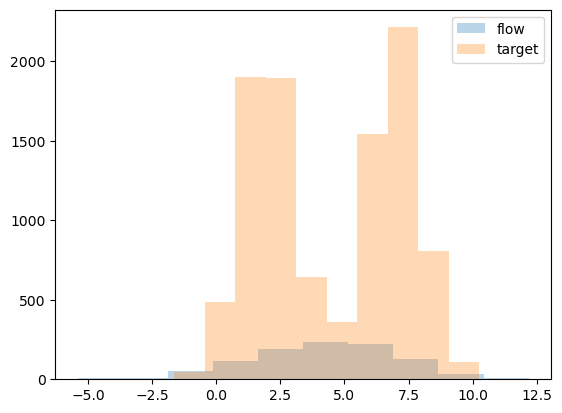

In [13]:
# plt.hist(*flow.sample(key, (1000, ), condition=jnp.zeros(1)).T, label="flow", alpha=0.3)
plt.hist(*flow.sample(key, (1000, ), condition=jnp.zeros(1)).T,label="flow", alpha=0.3)

# plt.hist(*flow.sample(key, (1000, ), condition=jnp.zeros(1)).T, label="flow", alpha=0.3)
plt.hist(*y.T, label="target", alpha=0.3)
plt.legend()

In [ ]:
print(flow.bijection.bijection.bijections[0].ate)
print(flow.bijection.bijection.bijections[0].const)
print(flow.bijection.bijection.bijections[0].scale)